# eICU Experiments

In [ ]:
!pip install shap

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    import tensorflow.compat.v1 as tf 
    tf.disable_v2_behavior()
except:
    import tensorflow as tf
    
import os
import h5py
import shap

from sklearn import metrics

In [5]:
# Dataset specific
n_clusters = 2
dataset = "eICU"
trans_mat_size = n_clusters
num_iter = 5
som_dim = [8, 8]
c_dim = 2
latent_dim = 100
batch_size =  300
lstm_dim = 200
num_pred = 6
max_n_step = 60
ex_name = "hyperopt_LSTM_100_8-8_2023-09-21_8c99d"

In [ ]:
datadir = "../data"

def get_data(filename, train_val_split_ratio=0.85):
    """Load the saved data and split into training, validation and test set.
    Args:
        train_val_split_ratio (float): Split of train-validation/test
        filename (str): Name of the data file
    Yields:
        np.array: Training data.
        np.array: Val/test data depending on validation value.
        np.array: Training labels.
        np.array: Val/test data depending on validation value.
    """
    hf = h5py.File(os.path.join(datadir, filename), "r")
    features = np.array(hf.get("x"))
    targets = np.array(hf.get("y"))

    print("data_total shape:", features.shape)
    print("endpoints_total shape", targets.shape)

    len_train = int(len(features) * train_val_split_ratio)

    features_train = features[:len_train]
    targets_train = targets[:len_train]
    features_val = features[len_train:]
    targets_val = targets[len_train:]

    return features_train, features_val, targets_train, targets_val

In [ ]:
def batch_generator(data_train, data_val, endpoints_total_train, endpoints_total_val, batch_size, mode="train"):
    while True:
        if mode == "train":
            for i in range(len(data_train) // batch_size):
                time_series = data_train[i * batch_size: (i + 1) * batch_size]
                time_series_endpoint = endpoints_total_train[i * batch_size: (i + 1) * batch_size]
                yield time_series,time_series_endpoint, i
        elif mode == "val":
            for i in range(len(data_val) // batch_size):
                time_series = data_val[i * batch_size: (i + 1) * batch_size]
                time_series_endpoint = endpoints_total_val[i * batch_size: (i + 1) * batch_size]
                yield time_series, time_series_endpoint, i
        else:
            raise ValueError(f"The mode has to be in {train, val}")

Get the data:

In [ ]:
modelpath = "../models/{}/{}".format(ex_name, ex_name)

data_train, data_val, endpoints_total_train, endpoints_total_val = get_data(
    filename="model_ready_data.h5"
)
(
    data_train_full,
    data_val_full,
    endpoints_total_train_full,
    endpoints_total_val_full,
) = get_data(filename="model_ready_data.h5")

# Truncated to max_n_step time steps only
data_train = data_train[:, :max_n_step, :]
data_val = data_val[:, :max_n_step, :]
endpoints_total_train = endpoints_total_train[:, :max_n_step, :]
endpoints_total_val = endpoints_total_val[:, :max_n_step, :]

## Create heat-maps, trajectories and probability distributions

In [ ]:
train_gen = batch_generator(
    data_train_full, 
    endpoints_total_train_full, 
    batch_size, 
)

In [9]:
num_batches = len(data_train_full) // batch_size

print("Num_batches: ", num_batches)

tf.reset_default_graph()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph(modelpath+".meta")
    saver.restore(sess, modelpath)
    graph = tf.get_default_graph()
    k = graph.get_tensor_by_name("k/k:0")
    z_e = graph.get_tensor_by_name("z_e_sample/z_e:0")
    x = graph.get_tensor_by_name("inputs/x:0")
    is_training = graph.get_tensor_by_name("is_training/is_training:0")
    graph = tf.get_default_graph()
    z_e_p = graph.get_tensor_by_name("prediction/next_state/input_lstm:0")
    q = graph.get_tensor_by_name("q/distribution/q:0")
    embeddings = graph.get_tensor_by_name("embeddings/embeddings:0")
    reconstruction = graph.get_tensor_by_name("reconstruction_e/x_hat:0")
    
    #added for CVAE
    x_trans_mat = graph.get_tensor_by_name("x_trans_mat_inputs/x_trans_mat:0")
    y_trans_mat = graph.get_tensor_by_name("y_trans_mat_inputs/y_trans_mat:0")
    c = graph.get_tensor_by_name("conditions/c:0")
    concat_x_c = graph.get_tensor_by_name("concatenated_inputs/concat_x_c:0")
    
    print("Evaluation...")
    test_k_all = []
    labels_val_all = []
    z_e_all=[]
    z_q_all = []
    qq = []
    
    for i in range(num_batches):
            batch_data, batch_labels, ii = next(train_gen)
            
            #added for CVAE
            batch_val_ts_data = batch_data[ :, :, trans_mat_size:]
            batch_val_trans_mat_x = batch_data[:, :, :trans_mat_size]
            batch_val_trans_mat_y = batch_labels[:, :, :trans_mat_size]
            batch_conditions = np.zeros((batch_data.shape[0], max_n_step, c_dim))
            batch_concat_x_c = np.concatenate((batch_val_ts_data, batch_conditions), axis=2)
            
            f_dic = {x: batch_val_ts_data, 
                     x_trans_mat:batch_val_trans_mat_x, 
                     y_trans_mat:batch_val_trans_mat_y, 
                     c:batch_conditions,
                     concat_x_c: batch_concat_x_c}
            
            test_k_all.extend(sess.run(k, feed_dict=f_dic))
            labels_val_all.extend(batch_labels)
            z_q_all.extend(sess.run(q, feed_dict=f_dic))
            qq.extend(sess.run(q, feed_dict=f_dic))
            z_e_all.extend(sess.run(z_e, feed_dict=f_dic))
            
            
    labels_val_all = np.array(labels_val_all)
    k_all = np.array(test_k_all)
    qq = np.array(qq)
    labels_val_all = np.reshape(labels_val_all, (-1, labels_val_all.shape[-1]))
    NMI_24 = metrics.normalized_mutual_info_score(labels_val_all[:, trans_mat_size + 3], k_all)
    NMI_12 = metrics.normalized_mutual_info_score(labels_val_all[:, trans_mat_size + 2], k_all)
    NMI_6 = metrics.normalized_mutual_info_score(labels_val_all[:, trans_mat_size + 1], k_all)
    NMI_1 = metrics.normalized_mutual_info_score(labels_val_all[:, trans_mat_size + 0], k_all)
    

In [9]:
labels_1 = labels_val_all[:,trans_mat_size + 0]
labels_6 = labels_val_all[:,trans_mat_size + 1]
labels_12 = labels_val_all[:,trans_mat_size + 2]
labels_24 = labels_val_all[:,trans_mat_size + 3]

hosp_disc_1 = labels_val_all[:,trans_mat_size + 4]
hosp_disc_6 = labels_val_all[:,trans_mat_size + 5]
hosp_disc_12 = labels_val_all[:,trans_mat_size + 6]
hosp_disc_24 = labels_val_all[:,trans_mat_size + 7]

u_disc_1 = labels_val_all[:,trans_mat_size + 8]
u_disc_6 = labels_val_all[:,trans_mat_size + 9]
u_disc_12 = labels_val_all[:,trans_mat_size + 10]
u_disc_24 = labels_val_all[:, trans_mat_size + 11]

labels_1 = labels_1.astype(int)
labels_6 = labels_6.astype(int)
labels_12 = labels_12.astype(int)
labels_24 = labels_24.astype(int)
hosp_disc_12 = hosp_disc_12.astype(int)
hosp_disc_24 = hosp_disc_24.astype(int)
hosp_disc_1 = hosp_disc_1.astype(int)
hosp_disc_6 = hosp_disc_6.astype(int)

### Moran Index

In [9]:
sd = som_dim[0]*som_dim[1]

mean = np.sum(labels_val_all[:, 0]) / len(labels_val_all[:, 0])
ones = np.ones((len(np.reshape(k_all, (-1)))))
clust_matr1 = np.zeros(som_dim[0]*som_dim[1])
labels= labels_val_all[:, trans_mat_size+ 0]
for i in range(som_dim[0]*som_dim[1]):
    dd = np.sum(ones[np.where(np.reshape(k_all, (-1))==i)])
    if dd == 0:
        s1 = 0
    else:
        s1 = np.sum(labels[np.where(np.reshape(k_all, (-1))==i)]) / np.sum(ones[np.where(np.reshape(k_all, (-1))==i)])
    clust_matr1[i] = s1

k = np.arange(0,sd)
k1 = k // som_dim[0]
k2 = k % som_dim[0]
W = np.zeros((sd,sd))
for i in range(sd):
    for j in range(sd):
        d1 = np.abs((k1[i] - k1[j]))
        d2 = np.abs((k2[i] - k2[j]))
        d1 = min(som_dim[0]-d1, d1)
        d2 = min(som_dim[0]-d2, d2)
        W[i,j] = np.exp(-(d1+d2))
        if i==j:
            W[i,j]=0
M = 0
N_n = 0
for i in range(sd):
    for j in range(sd):
        M += (clust_matr1[i] -mean)*(clust_matr1[j] -mean)* W[i,j]
for i in range(sd):
    N_n += (clust_matr1[i]-mean)**2
W_n = np.sum(W)
I = M * sd / (N_n*W_n)

print(I)

Num_batches:  29


2023-09-29 08:43:19.757050: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


INFO:tensorflow:Restoring parameters from ../models/hyperopt_LSTM_100_8-8_2023-09-21_8c99d/hyperopt_LSTM_100_8-8_2023-09-21_8c99d
Evaluation...
0.9893933956129544


# Generate cluster matrix

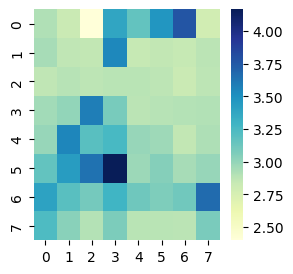

In [10]:
labels = labels_1
f = plt.figure(figsize=(3,3))
ones = np.ones((len(np.reshape(k_all, (-1)))))
clust_matr1 = np.zeros(som_dim[0]*som_dim[1])
clust_matr2 = np.zeros(som_dim[0]*som_dim[1])
for i in range(som_dim[0]*som_dim[1]):
    s1 = np.sum(labels[np.where(np.reshape(k_all, (-1))==i)]) / np.sum(ones[np.where(np.reshape(k_all, (-1))==i)])
    clust_matr1[i] = s1
clust_matr1 = np.reshape(clust_matr1, (som_dim[0],som_dim[1]))
ax = sns.heatmap(clust_matr1, cmap="YlGnBu")
plt.show()

### Trajectories

In [14]:
h = np.reshape(u_disc_6, (-1,max_n_step))

In [15]:
T = []
S = []
for i in range(h.shape[0]):
    if np.max(h[i]) == 1:
        T.append(i)
    else:
        S.append(i)

In [16]:
k_all = np.reshape(k_all, (-1, max_n_step))

In [171]:
patients_survived = np.array([3680, 3920, 6733, 341, 4470, 4647, 7308,60, 622, 8448, 1674, 1911, 2418, 6716, 7980, 4098, 5196, 1874, 50, 505])

a = patients_survived

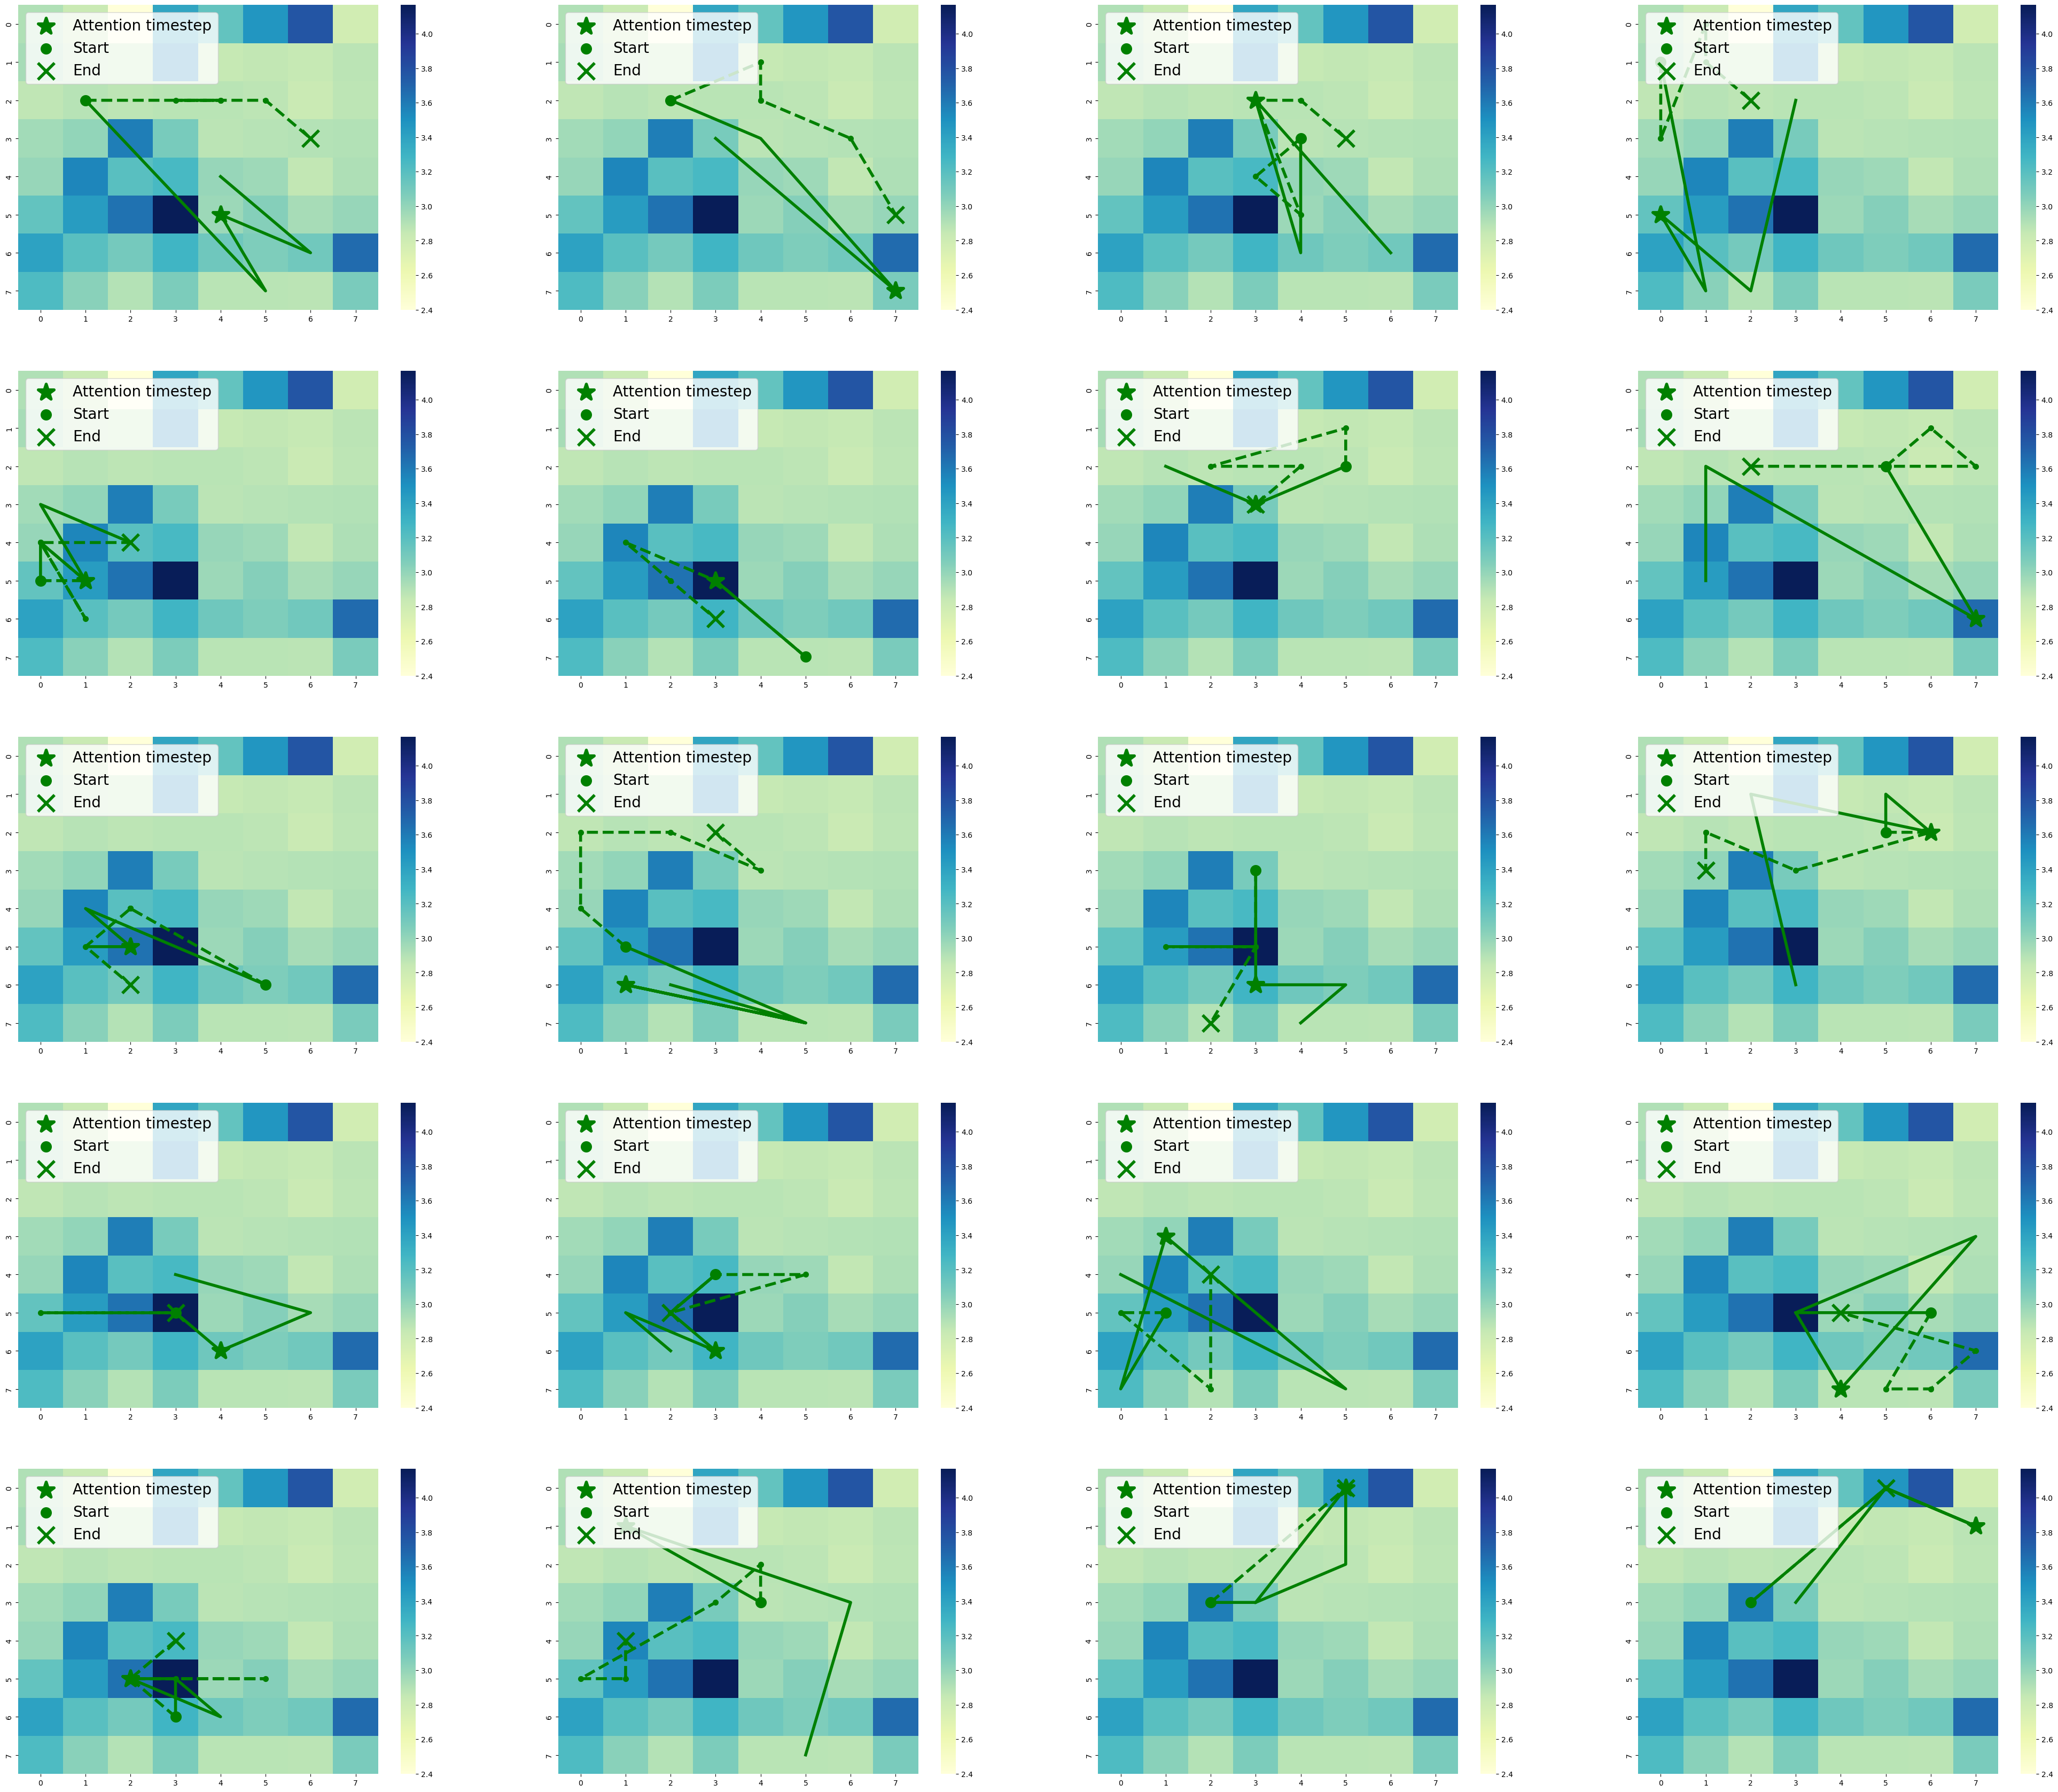

In [179]:
labels = labels_1
it = 0

fig, ax = plt.subplots(5, 4, figsize=(50,43)) 

ones = np.ones((len(np.reshape(k_all, (-1)))))

clust_matr1 = np.zeros(som_dim[0]*som_dim[1])
clust_matr2 = np.zeros(som_dim[0]*som_dim[1])
for i in range(som_dim[0]*som_dim[1]):
    s1 = np.sum(labels[np.where(np.reshape(k_all, (-1)) == i)]) / np.sum(ones[np.where(np.reshape(k_all, (-1))==i)])
    clust_matr1[i] = s1
clust_matr1 = np.reshape(clust_matr1, (som_dim[0],som_dim[1]))

for t in a:
    if it > 9:
        c = "g"
    else:
        c = "g"
        
    cc = it % 4
    rr = it // 4
    g = sns.heatmap(clust_matr1, cmap="YlGnBu", ax=ax[rr][cc])
    
    k_1 = k_all[t] // som_dim[1]
    k_2 = k_all[t] % som_dim[1]
    
    # #historical graph
    ax[rr][cc].plot(k_2[-10:-5] + 0.5, k_1[-10:-5] + 0.5, color=c, linewidth=4)
    # #attended timestep
    ax[rr][cc].scatter(k_2[-8] + 0.5, k_1[-8] + 0.5, color=c, s=500, linewidth=4, marker='*', label='Attention timestep')
    
    #forecasted timesteps
    ax[rr][cc].plot(k_2[-6:] + 0.5, k_1[-6:] + 0.5, color=c, linewidth=4, linestyle = "--")
    ax[rr][cc].scatter(k_2[-6] + 0.5, k_1[-6] + 0.5, color=c, s=200, label='Start')
    ax[rr][cc].scatter(k_2[-6:-1] + 0.5, k_1[-6:-1] + 0.5, color=c, linewidth=5, marker='.')
    ax[rr][cc].scatter(k_2[-1] + 0.5, k_1[-1] + 0.5, color=c, s=500, linewidth=4, marker='x', label='End')
    ax[rr][cc].legend(loc=2, prop={'size': 20})
    it +=1
plt.show()

## Explainability

In [ ]:
def model_cluster_inference(input_data):
    
    # Set Configurations
    modelpath = "../models/{}/{}".format(ex_name, ex_name)
    
    tf.reset_default_graph()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph(modelpath + ".meta")
        saver.restore(sess, modelpath)
        
        graph = tf.get_default_graph()
        
        k = graph.get_tensor_by_name("k/k:0")
        x = graph.get_tensor_by_name("inputs/x:0")
        x_trans_mat = graph.get_tensor_by_name("x_trans_mat_inputs/x_trans_mat:0")
        
        ts_data = np.expand_dims(input_data[:, trans_mat_size:], axis=0 )
        trans_mat_x_data = np.expand_dims(input_data[:, :trans_mat_size], axis=0 )
        
        k_all = []
        f_dic = {x: ts_data, x_trans_mat:trans_mat_x_data}
        k_all = sess.run(k, feed_dict=f_dic)

    return k_all
    

In [ ]:
input_data = np.reshape(data_train, (-1, data_train.shape[2]))
k_all = model_cluster_inference(input_data)

In [ ]:
class_explanations = []
for class_label in np.unique(k_all):
    print("class_label:", class_label)
    class_mask = (k_all == class_label)
    filtered_input = input_data[class_mask]    
    sampled_input = filtered_input[np.random.choice(filtered_input.shape[0], 10, replace=False)]

    explainer = shap.Explainer(model_cluster_inference, sampled_input)
    shap_values = explainer.shap_values(sampled_input)
    class_explanations.append(shap_values)

In [ ]:
with open("eICU_features.txt", "r") as f:
    eICU_features = f.readlines()

In [ ]:
cluster_dict = {}
index_feature_mapping = {}

for index, value in enumerate(eICU_features):
    cluster_dict[index] = value.split("\n")[0]
    index_feature_mapping[value.split("\n")[0]] = index

In [ ]:
cluster_feat_imp = {}
for i in range(len(class_explanations)):
    sv_cls = class_explanations[i]
    mean_sv = np.mean(sv_cls[:, config['trans_mat_size']:], axis=0)
    most_imp_feature = cluster_dict[np.abs(mean_sv).argmax()]
    cluster_feat_imp[i] = most_imp_feature

In [ ]:
train_gen = batch_generator(
    data_train, 
    endpoints_total_train, 
    batch_size, 
)

In [ ]:
def z_dist_flat(z_e, embeddings):
    """Computes the distances between the encodings and the embeddings."""
    # som_dim = som_dim
    # latent_dim = latent_dim
    emb = np.reshape(embeddings, (som_dim[0]*som_dim[1], -1))
    z = np.reshape(z_e, (z_e.shape[0], 1, latent_dim))
    z = np.tile(z, [1,som_dim[0]*som_dim[1], 1])
    z_dist = np.square(z-emb)
    z_dist_red = np.sum(z_dist, axis=-1)
    return z_dist_red

In [ ]:
%%time

from tqdm.notebook import tqdm, trange

num_batches = len(data_train) // batch_size
print("num_batches", num_batches)

tf.reset_default_graph()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph(modelpath + ".meta")
    saver.restore(sess, modelpath)
    
    graph = tf.get_default_graph()
    
    k = graph.get_tensor_by_name("k/k:0")
    x = graph.get_tensor_by_name("inputs/x:0")
    c = graph.get_tensor_by_name("conditions/c:0")
    z_e = graph.get_tensor_by_name("z_e_sample/z_e:0")
    next_z_e = graph.get_tensor_by_name("prediction/next_z_e:0")
    embeddings = graph.get_tensor_by_name("embeddings/embeddings:0")
    z_p = graph.get_tensor_by_name('reconstruction_e/decoder/z_e:0')
    is_training = graph.get_tensor_by_name("is_training/is_training:0")
    z_e_p = graph.get_tensor_by_name("prediction/next_state/input_lstm:0")
    init_1 = graph.get_tensor_by_name("prediction/next_state/init_state:0")
    state1 = graph.get_tensor_by_name("prediction/next_state/next_state:0")
    concat_x_c = graph.get_tensor_by_name("concatenated_inputs/concat_x_c:0")
    x_trans_mat = graph.get_tensor_by_name("x_trans_mat_inputs/x_trans_mat:0")
    y_trans_mat = graph.get_tensor_by_name("y_trans_mat_inputs/y_trans_mat:0")
    attention_weights = graph.get_tensor_by_name("prediction/next_state/attention_weights:0")
    
    #############################################################################
    #  I. Evaluating whole training data to generate heat map cluster matrix    #
    #############################################################################

    # -------------------------------------------- #
    # 1. Find all k_all of the full training data  #
    # -------------------------------------------- #
    print("Step-1")
    num_batches = len(data_train) // batch_size
    training_dic = {
        is_training: False,
        z_e_p: np.zeros((max_n_step, len(data_train), latent_dim)),
        init_1: np.zeros((2, batch_size, lstm_dim)),
        z_p: np.zeros((max_n_step * len(data_train), latent_dim + c_dim)),
    }
    k_all = []
    labels_all = []
    for i in trange(num_batches):
        batch_data, batch_labels, ii = next(train_gen)

        # Added for CVAE
        batch_ts_data = batch_data[:, :, trans_mat_size:]
        batch_trans_mat_x = batch_data[:, :, :trans_mat_size]
        batch_trans_mat_y = batch_labels[:, :, :trans_mat_size]
        labels_all.extend(batch_labels)

        batch_conditions = np.zeros((batch_ts_data.shape[0], max_n_step, c_dim))
        batch_concat_x_c = np.concatenate((batch_ts_data, batch_conditions), axis=2)
        f_dic = {
            x: batch_ts_data,
            x_trans_mat: batch_trans_mat_x,
            y_trans_mat: batch_trans_mat_y,
            c: batch_conditions,
            concat_x_c: batch_concat_x_c,
        }
        k_all.extend(sess.run(k, feed_dict=f_dic))

    k_all = np.array(k_all)
    k_all = k_all.reshape((-1, max_n_step))
    labels_all = np.array(labels_all)
    labels_all = np.reshape(labels_all, (-1, labels_all.shape[-1]))
    
    ######################################################################
    #  II. Evaluating whole validation data and generating all arrays    #
    ######################################################################
    print("Step-2")
    num_batches = len(data_train) // batch_size
    total_val_size = num_batches * batch_size
    training_dic = {
        is_training: True,
        z_e_p: np.zeros((max_n_step, len(data_train), latent_dim)),
        init_1: np.zeros((2, batch_size, lstm_dim)),
        z_p: np.zeros((max_n_step * len(data_train), latent_dim + c_dim)),
    }

    k_all = []
    z_e_all = []
    for i in trange(num_batches):
        batch_val_data, batch_val_labels, ii = next(train_gen)

        # Added for CVAE
        batch_val_ts_data = batch_val_data[:, :, trans_mat_size:]
        batch_val_trans_mat_x = batch_val_data[:, :, :trans_mat_size]
        batch_val_trans_mat_y = batch_val_labels[:, :, :trans_mat_size]

        batch_conditions = np.zeros((batch_val_ts_data.shape[0], max_n_step, c_dim))
        batch_concat_x_c = np.concatenate(
            (batch_val_ts_data, batch_conditions), axis=2
        )
        f_dic = {
            x: batch_val_ts_data,
            x_trans_mat: batch_val_trans_mat_x,
            y_trans_mat: batch_val_trans_mat_y,
            c: batch_conditions,
            concat_x_c: batch_concat_x_c,
        }

        k_all.extend(sess.run(k, feed_dict=f_dic))
        z_e_all.extend(sess.run(z_e, feed_dict=f_dic))

    z_e_all = np.array(z_e_all)
    k_all = np.array(k_all)

    z_e_all = z_e_all.reshape((-1, max_n_step, latent_dim))
    k_all = k_all.reshape((-1, max_n_step))

    #####################################################################################
    #  III. Generate embeddings for train data till (max_n_step - num_pred) step        #
    #####################################################################################
    print("Step-3")
    embeddings = sess.run(
        embeddings, feed_dict={x: data_val[:, :max_n_step, trans_mat_size:]}
    )
    embeddings = np.reshape(embeddings, (-1, latent_dim))
    
    z_e_o = z_e_all[:, :max_n_step, :]
    k_o = k_all[:, :max_n_step]
    next_z_e_o = []
    state1_o = []
    attention_weights_list = []
    attention_weights_for_all_at_t = []
    
    for i in trange(num_batches):
        batch_val_data, _, ii = next(train_gen)
        batch_val_data = batch_val_data[:, :max_n_step, :]

        # Added for CVAE
        batch_val_ts_data = batch_val_data[:, :, trans_mat_size:]
        batch_val_trans_mat_x = batch_val_data[:, :, :trans_mat_size]
        batch_conditions = np.zeros((batch_val_ts_data.shape[0], max_n_step, c_dim))
        batch_concat_x_c = np.concatenate(
            (batch_val_ts_data, batch_conditions), axis=2
        )
        f_dic = {
            x: batch_val_ts_data,
            x_trans_mat: batch_val_trans_mat_x,
            c: batch_conditions,
            concat_x_c: batch_concat_x_c,
        }
        f_dic.update(training_dic)

        next_z_e_o.extend(sess.run(next_z_e, feed_dict=f_dic))
        attention_weights_for_all_at_t.extend(
            sess.run(attention_weights, feed_dict=f_dic)
        )

        if i == 0:
            state1_o = sess.run(state1, feed_dict=f_dic)
        else:
            state1_o = np.concatenate(
                [state1_o, sess.run(state1, feed_dict=f_dic)], axis=1
            )
    next_z_e_o = np.array(next_z_e_o)
    state1_o = np.array(state1_o)
    next_z_e_o_all = np.reshape(next_z_e_o, (-1, max_n_step, latent_dim))
    k_next = np.argmin(
        z_dist_flat(next_z_e_o[:, -1, :], embeddings), axis=-1
    )
    k_o = np.concatenate([k_o, np.expand_dims(k_next, 1)], axis=1)

    # Added for attention explainations.
    attention_weights_for_all_at_t = np.array(attention_weights_for_all_at_t)
    attention_weights_list.append(attention_weights_for_all_at_t)
    attention_weights_list = np.array(attention_weights_list)
    
    ###########################################################################
    #  IV. Updated pred with sliced data and embeddings for each timestamp.   #
    ###########################################################################
    print("Step-4")
    for i in trange(num_pred - 1):
        inp = data_train_full[:total_val_size, i : (max_n_step + i), trans_mat_size:]
        inp_trans = data_train_full[
            :total_val_size, i : (max_n_step + i), :trans_mat_size
        ]

        batch_conditions = np.zeros((inp.shape[0], max_n_step, c_dim))
        batch_concat_x_c = np.concatenate((inp, batch_conditions), axis=2)

        f_dic = {x: inp, x_trans_mat: inp_trans}
        val_dic = {
            is_training: False,
            z_e_p: next_z_e_o,
            init_1: state1_o,
            z_p: np.zeros((max_n_step * len(inp), latent_dim + c_dim)),
            c: batch_conditions,
            concat_x_c: batch_concat_x_c,
        }
        f_dic.update(val_dic)
        next_z_e_o = sess.run(next_z_e, feed_dict=f_dic)
        state1_o = sess.run(state1, feed_dict=f_dic)
        k_next = np.argmin(
            z_dist_flat(next_z_e_o[:, -1, :], embeddings), axis=-1
        )
        k_o = np.concatenate([k_o, np.expand_dims(k_next, 1)], axis=1)

        # Storing Attention Weights for each prediction.
        attention_weights_o = sess.run(attention_weights, feed_dict=f_dic)
        # print("attention_weights_o.shape", attention_weights_o.shape)
        attention_weights_list = np.concatenate(
            [attention_weights_list, np.expand_dims(attention_weights_o, 0)], axis=0
        )
        # print("attention_weights_list.shape", attention_weights_list.shape)

        next_z_e_o_all = np.concatenate(
            [
                next_z_e_o_all,
                np.reshape(
                    next_z_e_o[:, -1, :],
                    (
                        next_z_e_o[:, -1, :].shape[0],
                        1,
                        next_z_e_o[:, -1, :].shape[1],
                    ),
                ),
            ],
            axis=1,
        )
        next_z_e_o = next_z_e_o_all[:, i + 1 :, :]

    k_o_pred = k_o[:, max_n_step:]
    
k_all_exp = k_all.copy()

In [ ]:
patient_died = [8198, 517, 3187]
player_index = patient_died[0]
player_att_map = attention_weights_list[-1, player_index, :, -1]
argmax_value = np.argmax(player_att_map[:-1])
cluster_id = k_all[player_index, argmax_value]
dominant_feature = cluster_feat_imp[cluster_id]

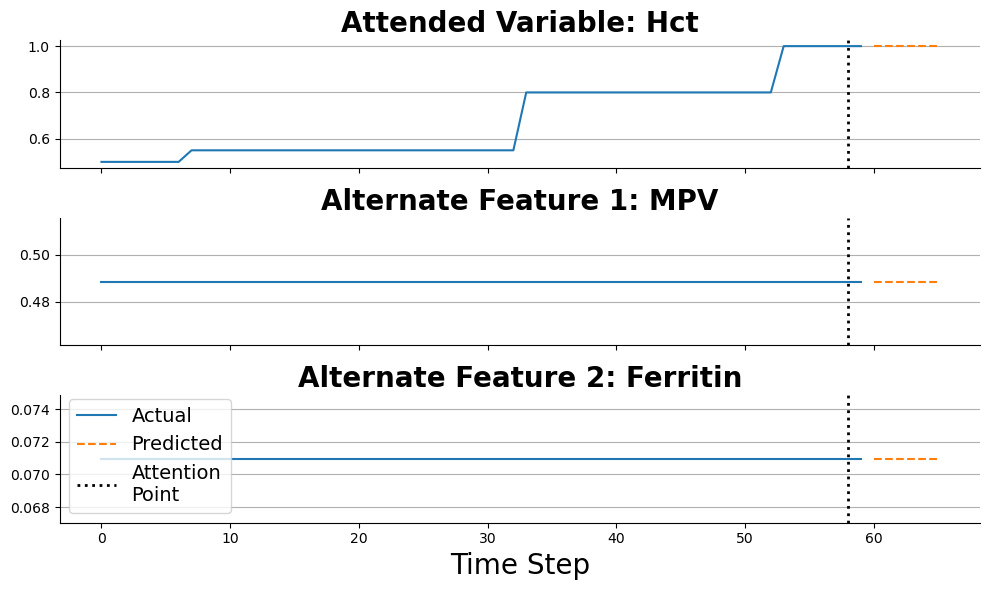

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

y_before = data_train_full[player_index, :max_n_step, trans_mat_size+index_feature_mapping[dominant_feature]]
y_after = data_train_full[player_index, max_n_step:, trans_mat_size+index_feature_mapping[dominant_feature]]

ax[0].plot(y_before, linestyle="solid", label="Actual")
ax[0].plot(range(max_n_step, max_n_step + num_pred), y_after, linestyle="dashed", label="Predicted")
ax[0].axvline(argmax_value, linestyle="dotted", color="black", linewidth=2, label="Attention\nPoint")
ax[0].spines[['right', 'top']].set_visible(False)
ax[0].grid(axis="y")
ax[0].set_title("Attended Variable: " + dominant_feature, fontweight="bold", fontsize=20)

y_before = data_train_full[player_index, : max_n_step, trans_mat_size+index_feature_mapping["MPV"]]
y_after = data_train_full[player_index, max_n_step :, trans_mat_size+index_feature_mapping["MPV"]]

ax[1].plot(y_before, linestyle="solid", label="Actual")
ax[1].plot(range(max_n_step, max_n_step + num_pred), y_after, linestyle="dashed", label="Predicted")
ax[1].axvline(argmax_value, linestyle="dotted", color="black", linewidth=2, label="Attention\nPoint")
ax[1].spines[['right', 'top']].set_visible(False)
ax[1].grid(axis="y")
ax[1].set_title("Alternate Feature 1: " + "MPV", fontweight="bold", fontsize=20)

y_before = data_train_full[player_index, : max_n_step, trans_mat_size+index_feature_mapping["Ferritin"]]
y_after = data_train_full[player_index, max_n_step :, trans_mat_size+index_feature_mapping["Ferritin"]]

ax[2].plot(y_before, linestyle="solid", label="Actual")
ax[2].plot(range(max_n_step, max_n_step + num_pred), y_after, linestyle="dashed", label="Predicted")
ax[2].axvline(argmax_value, linestyle="dotted", color="black", linewidth=2, label="Attention\nPoint")
ax[2].spines[['right', 'top']].set_visible(False)
ax[2].grid(axis="y")
ax[2].set_title("Alternate Feature 2: " + "Ferritin", fontweight="bold", fontsize=20)

_ = plt.xlabel("Time Step", fontsize=20)
_ = plt.tight_layout()
_ = plt.legend(loc="lower left", prop={"size": 14})